# Following of the krill catch data formating

In the first file we aggregated the raw data from the CCAMLR into a spatial grid.
Now we use this data to 
- calculate the average fishing intensity on different temporal period
- and on each cell accounting for the difference of area of the cells depending on their latitude.

In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import scipy
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
# To be change with local directory of the data (file too heavy to be on git)
# os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data/')
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration')
# load catch aggregated (from the previous file) and OCIM data to calculate the cell area
OCIM = xr.open_dataset('./outputs_formated_data/fseq_OCIM2_48L_interpolated_SO.nc')
catch = pd.read_csv('./outputs_formated_data/Krill_catch_aggregated.csv').drop(['Unnamed: 0'], axis = 1).set_index(['latitude', 'longitude'])

In the catch file we have the sum of the catch falling in a given cell, a given year.

In [3]:
catch

season_ccamlr  krill_greenweight_kg
latitude longitude                                     
-65.0    -73.0               1992               49840.0
-67.0    -69.0               1989                3250.0
-65.0    -69.0               1989                5950.0
         -69.0               1992                4300.0
         -69.0               1998               48875.0
...                           ...                   ...
          147.0              1990               19190.0
          149.0              1990                3840.0
          149.0              1991                3750.0
          149.0              1994                 200.0
          153.0              1991                2500.0

[1028 rows x 2 columns]

# Calculate the krill catch density (catch by constant spatial unit per cells)
In the previous sections we calculate the mean krill catch per cells over different period. Howerver, the cells have very different areas depending on their locations. Thus the catch intensity from one cell to another one is not comparable.

To resolve this we can use a constant area unit instead of the cell using the area of the cells in km². Thus we normalized (i.e., divided) the catch intensity in each cell by the area of the cell. Thus each record is now the krill fishing density in each cell in Kg of krill/(100 km per 100 km). 

In [4]:
# transform area array into a dataframe
area_df = OCIM[['AREA', 'MASK']].isel(depth=0).to_dataframe().drop(['depth'], axis = 1)

## calculate the area of the ocean (remove land) => multiply be the proportion of the ocean in cell (= MASK : 1=ocean, 0=land, or %o each)
area_df['True_area'] = area_df['AREA']*area_df['MASK']/(1000000 * 10000) # in square of 100 km per 100 km
area_df

AREA      MASK  True_area
latitude longitude                                   
-79      -179.0     9.332850e+09  0.061111   0.057034
         -177.0     9.332850e+09  0.061111   0.057034
         -175.0     9.332850e+09  0.061111   0.057034
         -173.0     9.332850e+09  0.061111   0.057034
         -171.0     9.332850e+09  0.061111   0.057034
...                          ...       ...        ...
-41       171.0     3.691131e+10  1.000000   3.691131
          173.0     3.691131e+10  0.272222   1.004808
          175.0     3.691131e+10  0.727778   2.686323
          177.0     3.691131e+10  1.000000   3.691131
          179.0     3.691131e+10  1.000000   3.691131

[3600 rows x 3 columns]

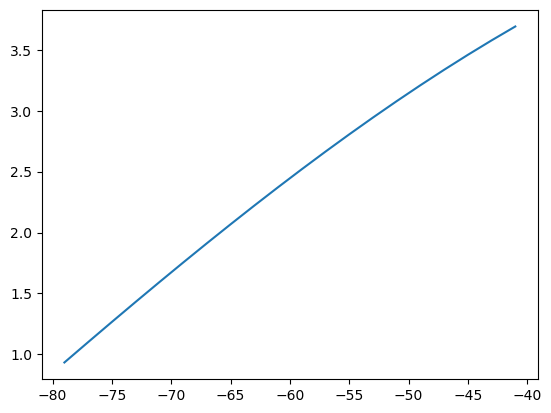

In [5]:
plt.plot(area_df.reset_index()['latitude'], area_df.reset_index()['AREA']/(1000000 * 10000)) # area unit is in 100 km x 100km = 10,000 km²

In [6]:
catch = catch.join(other = area_df['True_area'], how = 'left')
catch['krill_catch_density'] = catch['krill_greenweight_kg']/catch['True_area'] # catch density unit = Kg/10,000km²
catch

season_ccamlr  krill_greenweight_kg  True_area  \
latitude longitude                                                   
-69.0     5.0                1990          1.600000e+03   1.752802   
          7.0                1990          2.640000e-01   1.752802   
          9.0                1990          1.580000e-01   1.752802   
          13.0               1989          3.620000e+04   1.752802   
          29.0               1988          1.040000e+05   1.752802   
...                           ...                   ...        ...   
-53.0    -35.0               2023          3.563300e+07   2.943415   
         -7.0                1992          2.000000e+03   2.943415   
          35.0               1991          4.000000e+02   2.943415   
          37.0               1991          1.192300e+06   2.943415   
-51.0    -37.0               2004          7.274900e+04   3.077929   

                    krill_catch_density  
latitude longitude                       
-69.0     5.0              9.128240e+02  
          7.0              1.506160e-01  
          9.0              9.014137e-02  
          13.0             2.065264e+04  
          29.0             5.933356e+04  
...                                 ...  
-53.0    -35.0             1.210601e+07  
         -7.0              6.794829e+02  
          35.0             1.358966e+02  
          37.0             4.050738e+05  
-51.0    -37.0             2.363570e+04  

[1028 rows x 4 columns]

# Explore the temporal evolution of the catch

To see how the catch evolved over the period we can use the krill greenweight that was catch in the entire SO (here no need to use the catch density bc we consider the whole SO, so area variability does not matter).
We sum the catch by year over the SO.

In [7]:
# Sum the catch by year
temp_evo = catch.groupby(['season_ccamlr']).sum()

<Axes: xlabel='season_ccamlr'>

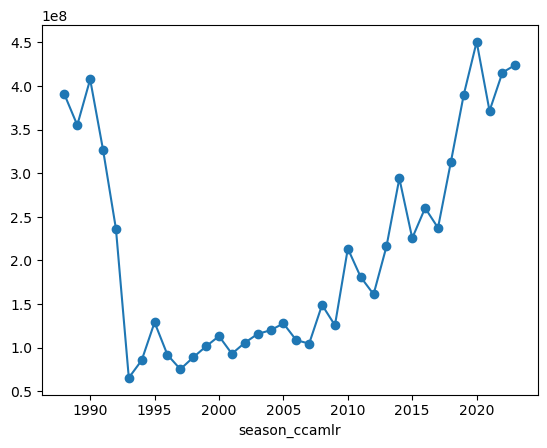

In [8]:
temp_evo['krill_greenweight_kg'].plot( marker='o')

In [9]:
temp_evo

,krill_greenweight_kg,True_area,krill_catch_density
season_ccamlr,,,
1988,3.905241e+08,167.354468,1.508173e+08
1989,3.552166e+08,135.856443,1.365336e+08
1990,4.077049e+08,254.387700,1.630158e+08
1991,3.269297e+08,173.248153,1.313676e+08
1992,2.363740e+08,90.169197,9.458933e+07
1993,6.549754e+07,117.952986,2.771355e+07
1994,8.555980e+07,69.889386,3.552101e+07
1995,1.290831e+08,66.950836,5.174444e+07
1996,9.178827e+07,57.677305,3.772965e+07


# Temporal average

Now we have a dataset with the fishing catch for each fishing season (year).
However we need a single map, so we need to aggregate the data temporally.

Thus we average the krill catch (not log) over a define temporal period:
- the whole periode (1988 - 2023)
- 1988 to 1999 (included)
- 2000 to 2011 (included)
- 2012 to 2023 (included)


/!\ All the years are not present in the data set > year with 0 catch are not reported. So the average of the catch or the catch density is not the more revlevant : thus we summed the densities to have comparable values of fishing intensity between all cells, both on the spatial and temporal aspects.

In [10]:
#separate the different periods
period1 = catch[catch['season_ccamlr'] < 2000] # 569 
period2 = catch[(catch['season_ccamlr'] < 2012) & (catch['season_ccamlr'] >= 2000)] # 193   
period3 = catch[catch['season_ccamlr'] >= 2012] # 266 

In [11]:
# to log the krill catch
def my_log(x):
    return np.log10(x+1)
    
# groupby cells (coords) and summ the catch (kg) and densities (kg/km²) across years
# for the density, calculate the annual mean density by dividing by the nb of years of each period
#all years (full period)
catch_all_years = catch.groupby(['latitude', 'longitude']).sum()
catch_all_years['krill_greenweight_kg'] = catch_all_years['krill_greenweight_kg']
catch_all_years['krill_catch_density'] = catch_all_years['krill_catch_density']/36
catch_all_years['krill_greenweight_kg_log'] = catch_all_years['krill_greenweight_kg'].apply(my_log) # sum of the catch (kg in a given cell)
catch_all_years['krill_catch_density_log'] = catch_all_years['krill_catch_density'].apply(my_log) # sum of the density of catch (kg/km²/year)
catch_all_years.drop(['True_area', 'season_ccamlr'], axis =1, inplace=True)

period1 = period1.groupby(['longitude', 'latitude']).sum()
period1['krill_greenweight_kg'] = period1['krill_greenweight_kg']
period1['krill_catch_density'] = period1['krill_catch_density']/12
period1['krill_greenweight_kg_log'] = period1['krill_greenweight_kg'].apply(my_log) 
period1['krill_catch_density_log'] = period1['krill_catch_density'].apply(my_log) 
period1.drop(['True_area', 'season_ccamlr'], axis =1, inplace=True)


period2 = period2.groupby(['longitude', 'latitude']).sum()
period2['krill_greenweight_kg'] = period2['krill_greenweight_kg']
period2['krill_catch_density'] = period2['krill_catch_density']/12
period2['krill_greenweight_kg_log'] = period2['krill_greenweight_kg'].apply(my_log) 
period2['krill_catch_density_log'] = period2['krill_catch_density'].apply(my_log)
period2.drop(['True_area', 'season_ccamlr'], axis =1, inplace=True)


period3 = period3.groupby(['longitude', 'latitude']).sum()
period3['krill_greenweight_kg'] = period3['krill_greenweight_kg']
period3['krill_catch_density'] = period3['krill_catch_density']/12
period3['krill_greenweight_kg_log'] = period3['krill_greenweight_kg'].apply(my_log) 
period3['krill_catch_density_log'] = period3['krill_catch_density'].apply(my_log)
period3.drop(['True_area', 'season_ccamlr'], axis =1, inplace=True)

array([[<Axes: title={'center': 'krill_greenweight_kg'}>,
        <Axes: title={'center': 'krill_catch_density'}>],
       [<Axes: title={'center': 'krill_greenweight_kg_log'}>,
        <Axes: title={'center': 'krill_catch_density_log'}>]],
      dtype=object)

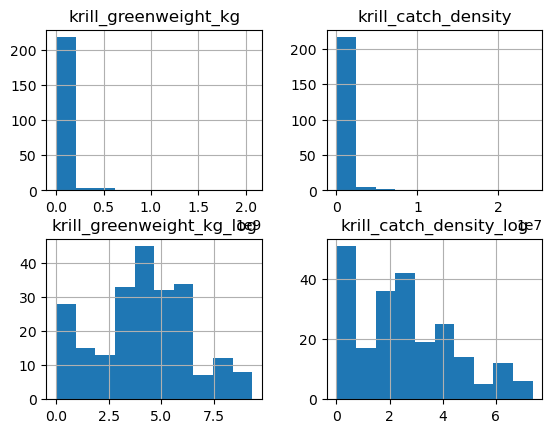

In [12]:
catch_all_years.hist()

# Transform in array and plot

In [13]:
# set index here with all coordinates
# make dataset with coordinates
coords = pd.DataFrame({'latitude':np.repeat(np.arange(-69, -50, 2), 180),
                       'longitude': np.tile(np.arange(-179, 180, 2), 10),
                       'label_grid': np.zeros(1800)}).set_index(['latitude', 'longitude'])

coords = coords.sort_values(['latitude', 'longitude'])

In [14]:
# for each of the datasets add the missing coords before ploting
catch_all_years = coords.join(catch_all_years, how='left').drop('label_grid' , axis =1) # 1800 rows, 4 non-nan rows
period1 = coords.join(period1, how='left').drop('label_grid' , axis =1)
period2 = coords.join(period2, how='left').drop('label_grid' , axis =1)
period3 = coords.join(period3, how='left').drop('label_grid' , axis =1)

In [15]:
#Keep only the catch in the file xarray (pb to plot otherwise)
xr_all_years = xr.Dataset.from_dataframe(catch_all_years)#.drop(['krill_greenweight_kg', 'krill_catch_density', 'krill_greenweight_kg_log'], axis =1)) # convert into xarrayDataset
# xr_all_years = xr.Dataset.to_array(xr_all_years) 

xr_period1 = xr.Dataset.from_dataframe(period1)#.drop(['krill_greenweight_kg', 'krill_catch_density', 'krill_greenweight_kg_log'], axis =1)) # convert into xarrayDataset
# xr_period1 = xr.Dataset.to_array(xr_period1) 

xr_period2 = xr.Dataset.from_dataframe(period2)#.drop(['krill_greenweight_kg', 'krill_catch_density', 'krill_greenweight_kg_log'], axis =1)) # convert into xarrayDataset
# xr_period2 = xr.Dataset.to_array(xr_period2) 

xr_period3 = xr.Dataset.from_dataframe(period3)#.drop(['krill_greenweight_kg', 'krill_catch_density', 'krill_greenweight_kg_log'], axis =1)) # convert into xarrayDataset
# xr_period3 = xr.Dataset.to_array(xr_period3)
xr_period3

<xarray.Dataset>
Dimensions:                   (latitude: 10, longitude: 180)
Coordinates:
  * latitude                  (latitude) int32 -69 -67 -65 -63 ... -55 -53 -51
  * longitude                 (longitude) int32 -179 -177 -175 ... 175 177 179
Data variables:
    krill_greenweight_kg      (latitude, longitude) float64 nan nan ... nan nan
    krill_catch_density       (latitude, longitude) float64 nan nan ... nan nan
    krill_greenweight_kg_log  (latitude, longitude) float64 nan nan ... nan nan
    krill_catch_density_log   (latitude, longitude) float64 nan nan ... nan nan

## Explore the distribution of fishing intensity

For the follwing overlap analysis we could use either the quantiles to slip the fishery intensity into categories, or a absolute threshold.

The fishing intensity is increase over the 3 period we consider thus the tier-tiles are very diferent between each period. 
Thus it is more relevant to use a unique threshold that we use to slip the fishing data on each period.
Howerver, instead of using a arbitrary boundary we define the threshold base on the distribution of the fishing intensity on the whole period considered (rather than on eac period separatly).

Thushere we explore the data to define this threashold. 

In [16]:
display(catch_all_years.describe(),
period1.describe(),
period2.describe(),
period3.describe())

,krill_greenweight_kg,krill_catch_density,krill_greenweight_kg_log,krill_catch_density_log
count,2.270000e+02,2.270000e+02,227.000000,227.000000
mean,3.379961e+07,4.786108e+05,4.159321,2.527983
std,1.780525e+08,2.507201e+06,2.246131,1.893472
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,6.885075e+02,8.014667e+00,2.838479,0.951791
50%,1.809045e+04,2.448045e+02,4.257473,2.390590
75%,4.575426e+05,6.608665e+03,5.660433,3.820170
max,2.068798e+09,2.423532e+07,9.315718,7.384449


,krill_greenweight_kg,krill_catch_density,krill_greenweight_kg_log,krill_catch_density_log
count,2.140000e+02,2.140000e+02,214.000000,214.000000
mean,1.100222e+07,3.702673e+05,4.001801,2.787509
std,5.292477e+07,1.796830e+06,2.194443,1.920148
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.689860e+02,1.520600e+01,2.567694,1.208368
50%,1.576503e+04,7.054825e+02,4.197661,2.849083
75%,3.996085e+05,1.552431e+04,5.601288,4.190960
max,5.427970e+08,1.907609e+07,8.734637,7.280489


,krill_greenweight_kg,krill_catch_density,krill_greenweight_kg_log,krill_catch_density_log
count,4.700000e+01,4.700000e+01,47.000000,47.000000
mean,3.315271e+07,1.143294e+06,5.798299,4.367858
std,9.292774e+07,3.263269e+06,1.661113,1.650208
min,2.000000e+02,6.616308e+00,2.303196,0.881744
25%,3.496050e+04,1.639439e+03,4.509059,3.212454
50%,4.420000e+05,1.553367e+04,5.645423,4.191302
75%,1.278135e+07,6.019960e+05,7.105772,5.759226
max,5.748048e+08,2.020097e+07,8.759520,7.305372


,krill_greenweight_kg,krill_catch_density,krill_greenweight_kg_log,krill_catch_density_log
count,4.300000e+01,4.300000e+01,43.000000,43.000000
mean,8.743858e+07,4.487487e+06,5.403321,4.124058
std,2.096769e+08,1.195744e+07,2.634079,2.437011
min,1.897000e-01,7.119374e-03,0.075437,0.003081
25%,5.104710e+03,1.961744e+02,3.679075,2.271362
50%,9.382659e+05,3.103928e+04,5.972326,4.491926
75%,3.920137e+07,2.243956e+06,7.571510,6.322191
max,9.511961e+08,6.398280e+07,8.978270,7.806063


#### Saving files

In [17]:
os.getcwd()

'C:\\Users\\anael\\Documents\\PhD\\4_krill_fisheries_Carbon_seq_time\\Git_repo\\Key_Areas_krill_carbon_sequestration'

In [18]:
#save files
# os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data')

#save xarray af the temporal average over the entire period
xr_all_years.to_netcdf('./outputs_formated_data/Krill_catch_array_final_all.nc')

# save xarray of the temporal average over the three periods
xr_period1.to_netcdf('./outputs_formated_data/Krill_catch_array_final_1.nc')
xr_period2.to_netcdf('./outputs_formated_data/Krill_catch_array_final_2.nc')
xr_period3.to_netcdf('./outputs_formated_data/Krill_catch_array_final_3.nc')

# Save the dataframe as csv with all relevant data
catch_all_years.to_csv('./outputs_formated_data/Krill_catch_final.csv')
period1.to_csv('./outputs_formated_data/Krill_catch_final_1.csv')
period2.to_csv('./outputs_formated_data/Krill_catch_final_2.csv')
period3.to_csv('./outputs_formated_data/Krill_catch_final_3.csv')